In [1]:
import _init_paths
import nengo_dl
import nengo
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pickle

from configs.exp_configs import tf_exp_cfg as exp_cfg, nengo_dl_cfg as ngo_cfg
from utils.base_utils.data_prep_utils import get_batches_of_cifar_data
from utils.base_utils.exp_utils import collect_sim_data_spikes, plot_ndl_layer_spikes
from utils.nengo_dl_utils import get_nengo_dl_model
from utils.consts.dir_consts import EXP_OTPT_DIR
from utils.consts.exp_consts import SEED

# Get the batched Test Data, the Nengo-DL Model

In [2]:
batches = get_batches_of_cifar_data(ngo_cfg, is_test=True)

In [3]:
print(exp_cfg)
print(ngo_cfg)

{'rf': 5e-05, 'batch_size': 200, 'epochs': 20, 'lr': 0.001, 'nn_dlyr': 512, 'tf_model': {'name': 'model_1', 'layers': {'layer_1': Layer(num_kernels=32, kernel_dims=(3, 3), stride_dims=(1, 1)), 'layer_2': Layer(num_kernels=64, kernel_dims=(3, 3), stride_dims=(1, 1)), 'layer_3': Layer(num_kernels=64, kernel_dims=(3, 3), stride_dims=(2, 2)), 'layer_4': Layer(num_kernels=96, kernel_dims=(3, 3), stride_dims=(2, 2)), 'layer_5': Layer(num_kernels=128, kernel_dims=(3, 3), stride_dims=(2, 2))}}, 'tf_wts_otpt_dir': '/scratch/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/tf_trained_wts/'}
{'tf_wts_inpt_dir': '/scratch/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/tf_trained_wts/weights', 'ndl_res_otpt_dir': '/scratch/rgaurav//spiking_investigation/experiment_outputs//cifar10/model_1/ndl_relu_results/', 'spk_neuron': SpikingRectifiedLinear(), 'synapse': 0.005, 'sfr': 250, 'n_steps': 60, 'test_batch_size': 100, 'train_batch_size': 200}



# Create the Simulator and do inference (TF - ReLU neuron)

In [4]:
ngo_cfg["spk_neuron"], ngo_cfg["synapse"], ngo_cfg["sfr"], ngo_cfg["n_steps"] = (
    nengo.RectifiedLinear(), None, 1, 1)
nengo_model, nengo_probes_obj_lst = get_nengo_dl_model(
    (32, 32, 3), exp_cfg, ngo_cfg)

/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:588: UserWarning: Activation type <function softmax at 0x2abb7d0de170> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation


In [5]:
ndl_model_otpt = []
ndl_model_spks = []

with nengo_model.net:
  nengo_dl.configure_settings(stateful=False)

with nengo_dl.Simulator(
  nengo_model.net, minibatch_size=ngo_cfg["test_batch_size"], progress_bar=True, seed=SEED) as sim:
  nengo_input = nengo_probes_obj_lst[0]
  nengo_output = nengo_probes_obj_lst[-1]
  batch_num=1
  for batch in batches:
    sim_data = sim.predict_on_batch({nengo_input: batch[0]})
    for y_true, y_pred in zip(batch[1], sim_data[nengo_output]):
      ndl_model_otpt.append((np.argmax([y_true]), np.argmax(y_pred[-1]), y_pred))
    if batch_num == 1: # Collect only for one batch, else memory consumption is too high.
      mdl_spks = collect_sim_data_spikes(nengo_probes_obj_lst, sim_data)
      ndl_model_spks.extend(mdl_spks)
    print("Batch: %s Done." % batch_num)
    batch_num += 1

Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Batch: 1 Done.raph: build stage finished in 0:00:00                            
Batch: 2 Done.
Batch: 3 Done.
Batch: 4 Done.
Batch: 5 Done.
Batch: 6 Done.
Batch: 7 Done.
Batch: 8 Done.
Batch: 9 Done.
Batch: 10 Done.
Batch: 11 Done.
Batch: 12 Done.
Batch: 13 Done.
Batch: 14 Done.
Batch: 15 Done.
Batch: 16 Done.
Batch: 17 Done.
Batch: 18 Done.
Batch: 19 Done.
Batch: 20 Done.
Batch: 21 Done.
Batch: 22 Done.
Batch: 23 Done.
Batch: 24 Done.
Batch: 25 Done.
Batch: 26 Done.
Batch: 27 Done.
Batch: 28 Done.
Batch: 29 Done.
Batch: 30 Done.
Batch: 31 Done.
Batch: 32 Done.
Batch: 33 Done.
Batch: 34 Done.
Batch: 35 Done.
Batch: 36 Done.
Batch: 37 Done.
Batch: 38 Done.
Batch: 39 Done.
Batch: 40 Done.
Batch: 41 Done.
Batch: 42 Done.
Batch: 43 Done.
Batch: 44 Done.


In [6]:
acc = 0
for y_true, y_pred, _ in ndl_model_otpt:
  if y_true == y_pred:
    acc += 1

print(acc/10000)

0.7238


# Create the Simulator and do inference (Nengo-DL - SpikingReLU neuron)

In [4]:
# ngo_cfg["spk_neuron"], ngo_cfg["synapse"], ngo_cfg["sfr"], ngo_cfg["n_steps"] = (
#     nengo.SpikingRectifiedLinear(), 0.005, 250, 60)
nengo_model, nengo_probes_obj_lst = get_nengo_dl_model(
    (32, 32, 3), exp_cfg, ngo_cfg)

/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:588: UserWarning: Activation type <function softmax at 0x2b438439de60> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation


In [5]:
nengo_model.net.ensembles

[<Ensemble "conv2d.0" at 0x2b43e7ed3790>,
 <Ensemble "conv2d_1.0" at 0x2b43e6182e10>,
 <Ensemble "conv2d_2.0" at 0x2b43e4b74fd0>,
 <Ensemble "conv2d_3.0" at 0x2b439f85db50>,
 <Ensemble "conv2d_4.0" at 0x2b439f852550>,
 <Ensemble "dense.0" at 0x2b439f86d150>,
 <Ensemble "dense_1.0" at 0x2b439f87ebd0>]

In [7]:
nengo_model.net.ensembles[0].neurons[:100]

<Neurons at 0x2b440791f950 of <Ensemble "conv2d.0" at 0x2b43e7ed3790>>[:100]

In [8]:
ndl_model_otpt = []
ndl_model_spks = []

with nengo_model.net:
  nengo_dl.configure_settings(stateful=False)
  #################################################
  conv0_spikes = nengo.Probe(nengo_model.net.ensembles[0].neurons[:100])
  conv0_values = nengo.Probe(nengo_model.net.ensembles[0].neurons[:100], synapse=0.005)
  #################################################

with nengo_dl.Simulator(
  nengo_model.net, minibatch_size=ngo_cfg["test_batch_size"], progress_bar=True, seed=SEED) as sim:
  nengo_input = nengo_probes_obj_lst[0]
  nengo_output = nengo_probes_obj_lst[-1]
  batch_num=1
  for batch in batches:
    sim_data = sim.predict_on_batch({nengo_input: batch[0]})
    print("Nengo Output Shape: ", sim_data[nengo_output].shape, "Test Batch Input Shape: ", batch[0].shape)
    for y_true, y_pred in zip(batch[1], sim_data[nengo_output]):
      ndl_model_otpt.append((np.argmax([y_true]), np.argmax(y_pred[-1]), y_pred))
    if batch_num == 1: # Collect only for one batch, else memory consumption is too high.
      #mdl_spks = collect_sim_data_spikes(nengo_probes_obj_lst, sim_data)
      #ndl_model_spks.extend(mdl_spks)
      print("Here")
      break
    print("Batch: %s Done." % batch_num)
    batch_num += 1

Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
Nengo Output Shape:  (100, 60, 10) Test Batch Input Shape:  (100, 60, 3072)    
Here


In [14]:
print(sim_data[conv0_values].shape)

(100, 60, 100)


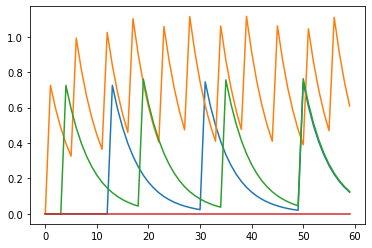

In [15]:
plt.plot(sim_data[conv0_values][0][:,0:4])

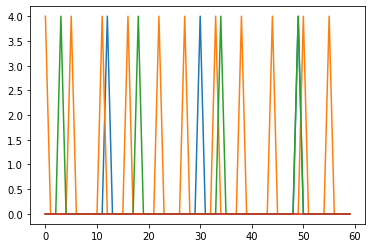

In [16]:
plt.plot(sim_data[conv0_spikes][0][:,0:4])

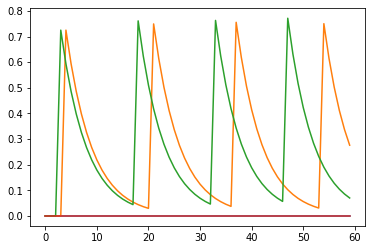

In [19]:
plt.plot(sim_data[conv0_values][0][:,45:49])

In [6]:
sim_data[nengo_output][0].shape

(60, 10)

In [7]:
acc = 0
for y_true, y_pred, _ in ndl_model_otpt:
  if y_true == y_pred:
    acc += 1

print(acc/10000)
# latest-nengo-tf environment: 0.7102 Test Accuracy with Nengo-DL.

0.7102


In [6]:
acc = 0
for y_true, y_pred, _ in ndl_model_otpt:
  if y_true == y_pred:
    acc += 1

print(acc/10000)
# latest-nengo-tf environment: 0.7102 Test Accuracy with Nengo-DL.

0.7045


In [11]:
ndl_model_spks[0]["conv2d.0"].shape
# latest-nengo-tf environment: (60, 32768) shape.

(60, 32768)

## Inference with Encoders, Bias, Gain, Plots, etc. for 100th batch

Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
Batch: 1 Done.raph: build stage finished in 0:00:00                            
Batch: 2 Done.
Batch: 3 Done.
Batch: 4 Done.
Batch: 5 Done.
Batch: 6 Done.
Batch: 7 Done.
Batch: 8 Done.
Batch: 9 Done.
Batch: 10 Done.
Batch: 11 Done.
Batch: 12 Done.
Batch: 13 Done.
Batch: 14 Done.
Batch: 15 Done.
Batch: 16 Done.
Batch: 17 Done.
Batch: 18 Done.
Batch: 19 Done.
Batch: 20 Done.
Batch: 21 Done.
Batch: 22 Done.
Batch: 23 Done.
Batch: 24 Done.
Batch: 25 Done.
Batch: 26 Done.
Batch: 27 Done.
Batch: 28 Done.
Batch: 29 Done.
Batch: 30 Done.
Batch: 31 Done.
Batch: 32 Done.
Batch: 33 Done.
Batch: 34 Done.
Batch: 35 Done.
Batch: 36 Done.
Batch: 37 Done.
Batch: 38 Done.
Batch: 39 Done.
Batch: 40 Done.
Batch: 41 Done.
Batch: 42 Done.
Batch: 43 Done.
Batch: 44 Done.


Layer: <Neurons of <Ensemble "dense_1.0">>, Neuron Type: SpikingRectifiedLinear(), Number of Neurons: 512, Seed: None
Unique Encoders: [-1.  1.]
Unique Scaled Encoders: [-250.  250.]
Unique bias: [-16.596867   -16.086958   -14.831557   -14.691134   -14.611807
 -13.738318   -13.630862   -13.2623825  -12.944134   -12.797046
 -12.792743   -12.685905   -12.175758   -12.06937    -11.895244
 -11.780007   -11.716323   -11.4176655  -11.330973   -11.25189
 -10.646992   -10.461303   -10.350978   -10.1244755  -10.1209345
  -9.686226    -9.663896    -9.657665    -9.455509    -9.398991
  -9.312045    -9.261436    -9.253885    -9.228938    -9.203854
  -9.1804695   -9.14452     -8.973607    -8.969103    -8.928916
  -8.908138    -8.886368    -8.821202    -8.793776    -8.724362
  -8.702571    -8.697006    -8.676716    -8.661925    -8.648948
  -8.625885    -8.584998    -8.553399    -8.506049    -8.497321
  -8.45445     -8.38837     -8.387947    -8.347941    -8.289548
  -8.226725    -8.14982     -8.13987

Batch: 100 Done.


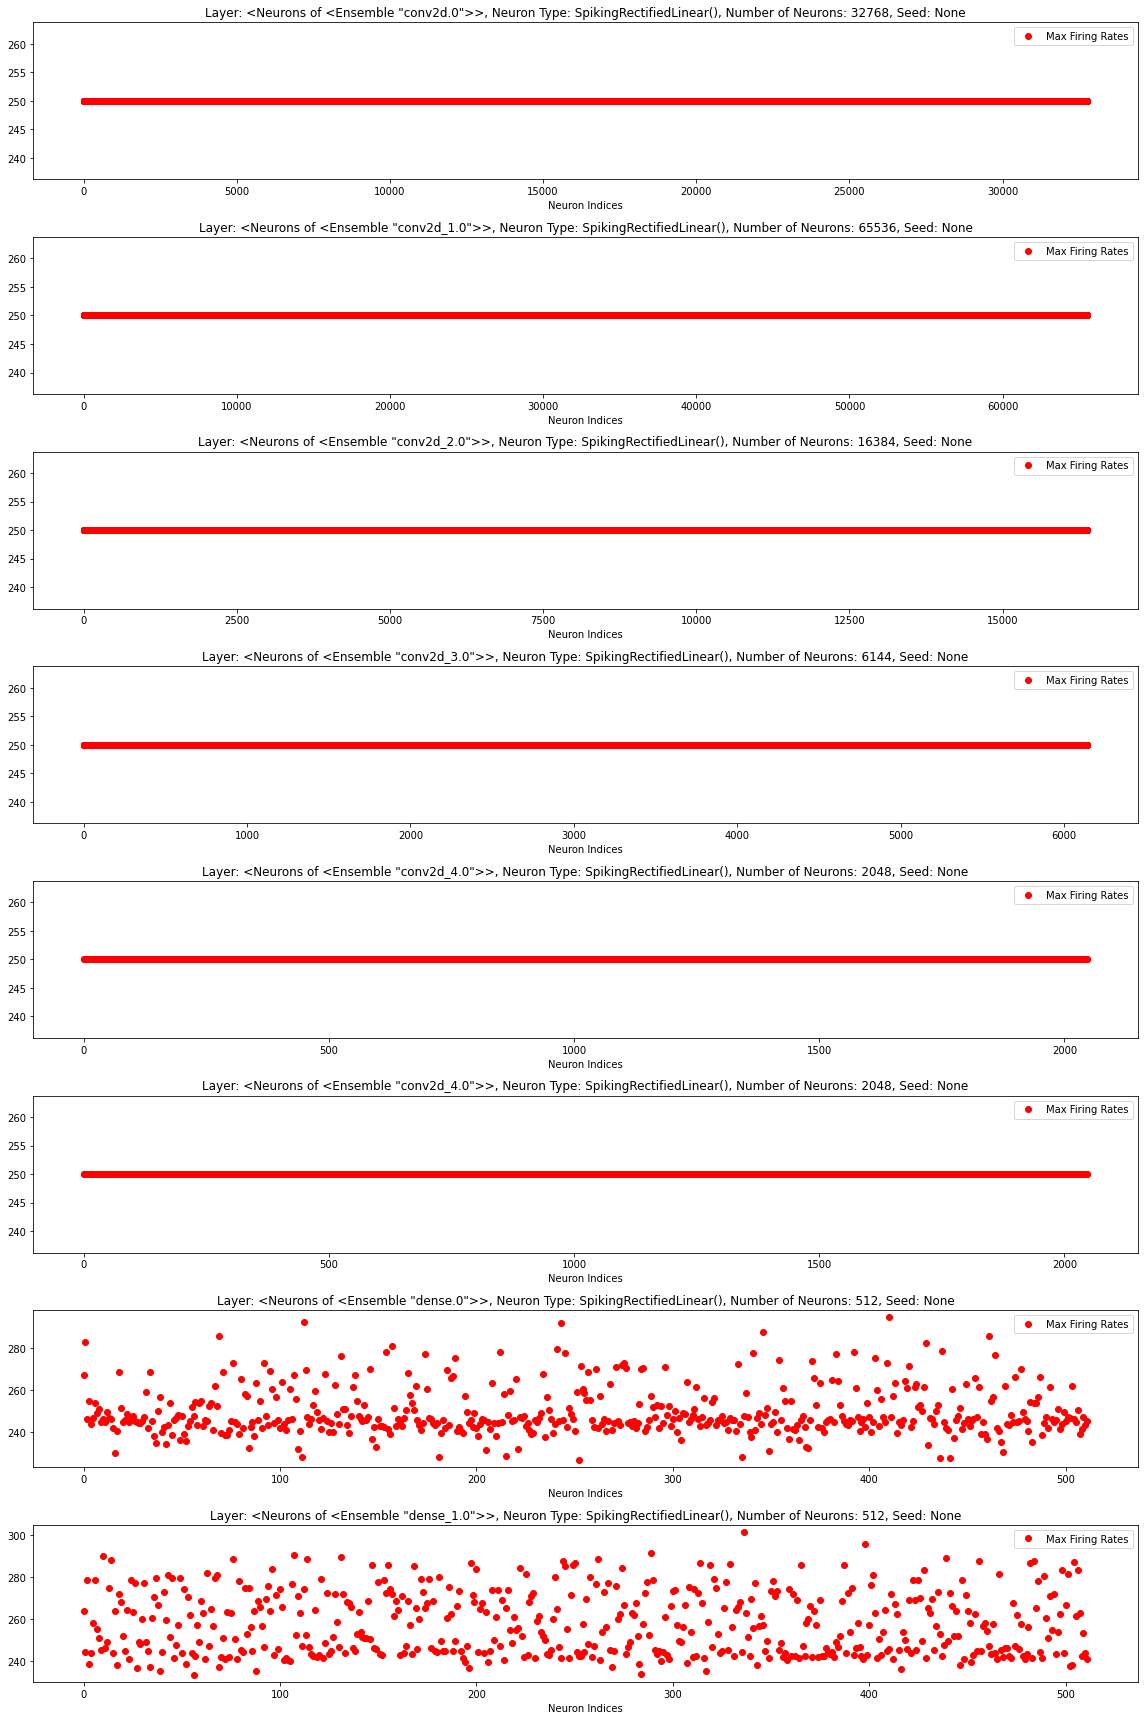

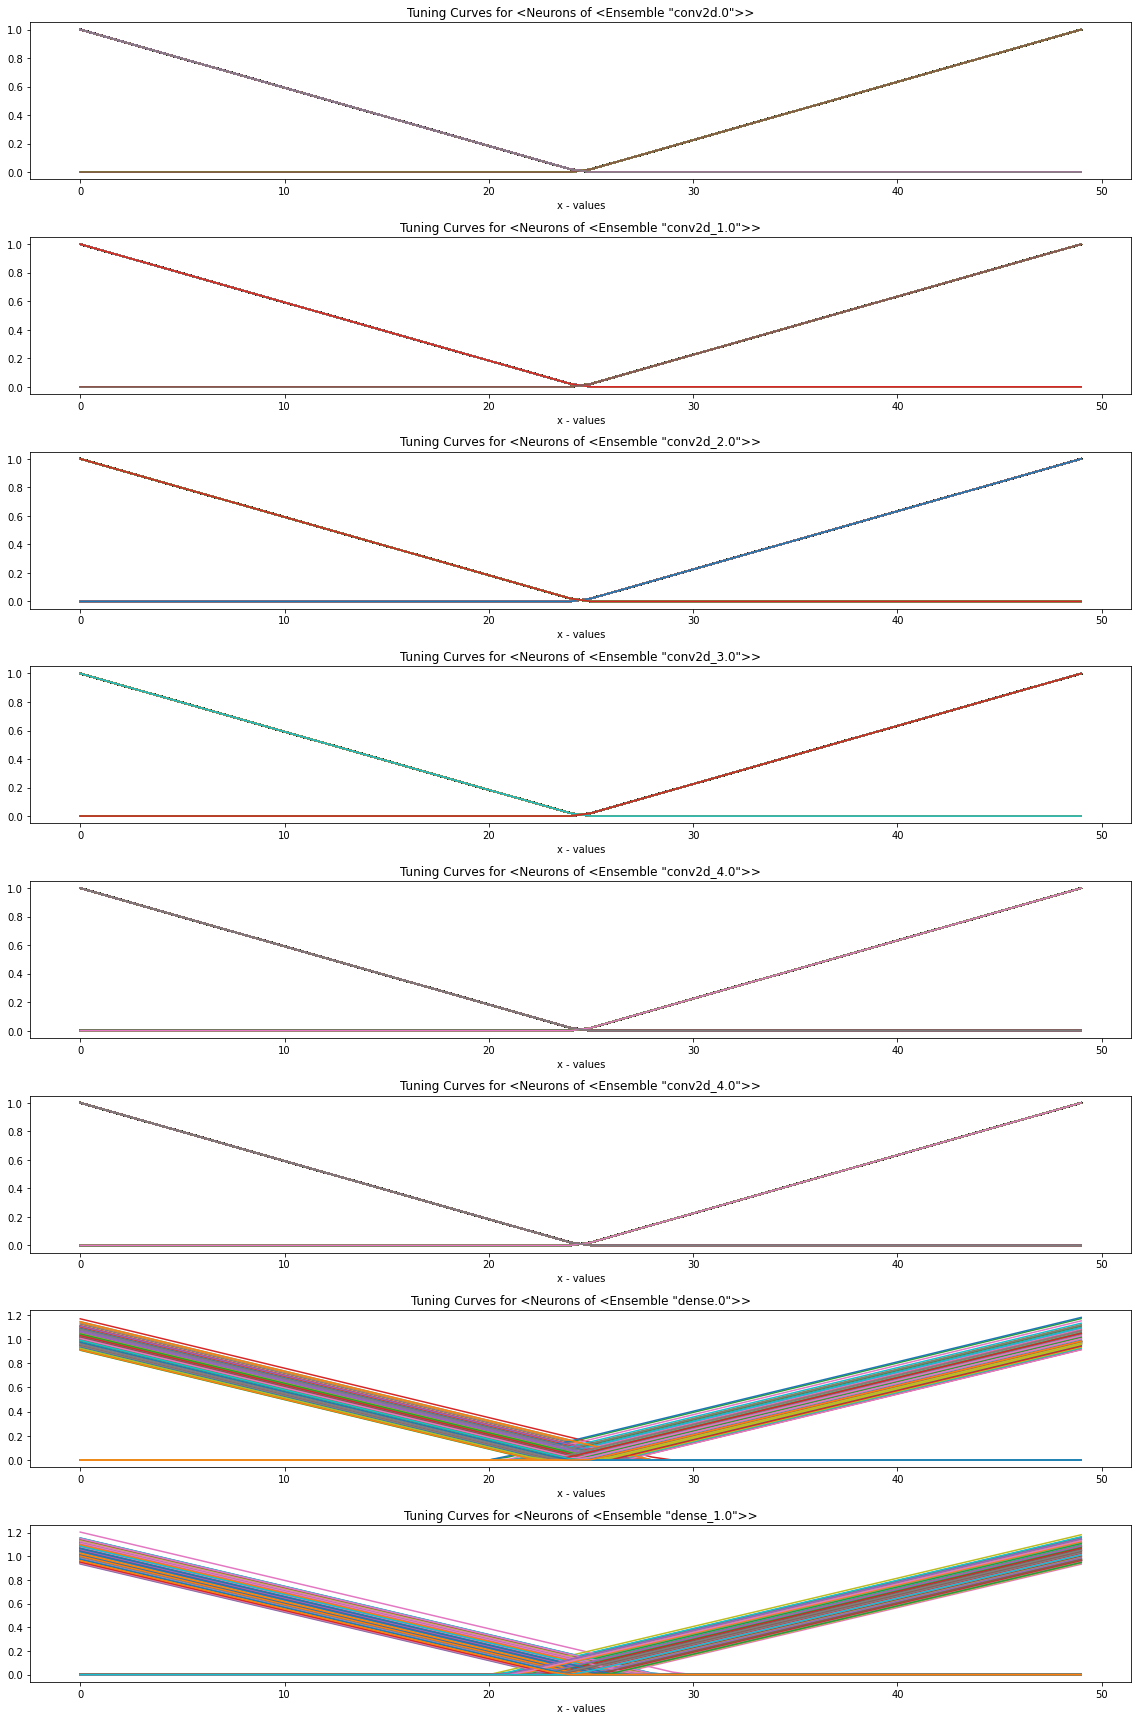

In [6]:
ndl_model_otpt = []
ndl_model_spks = []

with nengo_model.net:
  nengo_dl.configure_settings(stateful=False)

with nengo_dl.Simulator(
  nengo_model.net, minibatch_size=ngo_cfg["test_batch_size"], progress_bar=True, seed=SEED) as sim:
  nengo_input = nengo_probes_obj_lst[0]
  nengo_output = nengo_probes_obj_lst[-1]
  batch_num=1
  for batch in batches:
    sim_data = sim.predict_on_batch({nengo_input: batch[0]})
    for y_true, y_pred in zip(batch[1], sim_data[nengo_output]):
      ndl_model_otpt.append((np.argmax([y_true]), np.argmax(y_pred[-1]), y_pred))
    if batch_num == 1: # Collect only for one batch, else memory consumption is too high.
      mdl_spks = collect_sim_data_spikes(nengo_probes_obj_lst, sim_data)
      ndl_model_spks.extend(mdl_spks)
    print("Batch: %s Done." % batch_num)
    batch_num += 1
    if batch_num == 100:
        layers = list(nengo_model.layers.dict.values())[1:-1]
        fig, axs = plt.subplots(len(layers), figsize=(16, 3*len(layers)))
        fig1, axs1 = plt.subplots(len(layers), figsize=(16, 3*len(layers)))
        for i, layer in enumerate(layers):
            ens = layer.ensemble
            axs[i].set_title("Layer: {0}, Neuron Type: {1}, Number of Neurons: {2}, Seed: {3}".format(
                ens.neurons, ens.neuron_type, ens.n_neurons, ens.seed))
            axs[i].plot(sim.data[ens].max_rates, 'ro', label="Max Firing Rates")
            print("Layer: {0}, Neuron Type: {1}, Number of Neurons: {2}, Seed: {3}".format(
                ens.neurons, ens.neuron_type, ens.n_neurons, ens.seed))
            print("Unique Encoders: {}".format(np.unique(sim.data[ens].encoders)))
            print("Unique Scaled Encoders: {}".format(np.unique(sim.data[ens].scaled_encoders)))
            print("Unique bias: {}".format(np.unique(sim.data[ens].bias)))
            print("Unique gain: {}".format(np.unique(sim.data[ens].gain)))
            print("Unique intercepts: {}".format(np.unique(sim.data[ens].intercepts)))
            axs[i].legend()
            axs[i].set_xlabel("Neuron Indices")
            print("*"*100)
            axs1[i].set_title("Tuning Curves for {}".format(ens.neurons))
            x, act_mat = nengo.utils.ensemble.tuning_curves(ens, sim)
            for j in range(ens.n_neurons):
                axs1[i].plot(act_mat[:, j])
            axs1[i].set_xlabel("x - values")
        fig.tight_layout()
        fig.show()
        fig1.tight_layout()
        fig1.show()

In [7]:
pickle.dump({"acc_res": ndl_model_otpt, "spk_res": ndl_model_spks}, 
            open(ngo_cfg["ndl_res_otpt_dir"]+"ndl_%s_results_sfr_%s_nstps_%s.p" 
                % (exp_cfg["tf_model"]["name"], ngo_cfg["sfr"], ngo_cfg["n_steps"]), "wb"))

In [8]:
acc = 0
for y_true, y_pred, _ in ndl_model_otpt:
  if y_true == y_pred:
    acc += 1

print(acc/10000)

0.7117


In [5]:
# SFR = 1, N_STEPS=80, ACC: 10% random (No layer spikes)
# SFR = 50, N_STEPS=80, ACC: 42.1 (output layer starts spiking after 70ms)
# SFR = 100, N_STEPS=80, ACC: 60.73 (output layer starts spiking after 50ms)
# SFR = 200, N_STEPS=80, ACC: 63.85 (output layer starts spiking after 35ms)
# SFR = 250, N_STEPS=80, ACC: 64.56 (output layer starts spiking after 30ms)
# SFR = 600, N_STEPS=80, ACC: 64.98 (output layer starts spiking after 20ms)


# SFR = 250, N_STEPS=60, ACC: 63.85 (Same spiking pattern as N_STEPS=80)
# SFR = 250, N_STEPS=55, ACC: 62.21 (Same spiking pattern as N_STEPS=80)
# SFR = 250, N_STEPS=50, ACC: 60.02 (Same spiking pattern as N_STEPS=80)
# SFR = 250, N_STEPS=40, ACC: 40.87 (Same spiking pattern as N_STEPS=80)


# As you lower down the SFR (and keep the N_STEPS fixed), it takes longer for the output layer to spike.
# 

acc = 0
for y_true, y_pred, _ in ndl_model_otpt:
  if y_true == y_pred:
    acc += 1

print(acc/10000)

0.6383


In [9]:
ndl_model_spks[0]["conv2d.0"].shape

(60, 32768)

In [12]:
nengo_model.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 96)          55392     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         110720    
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

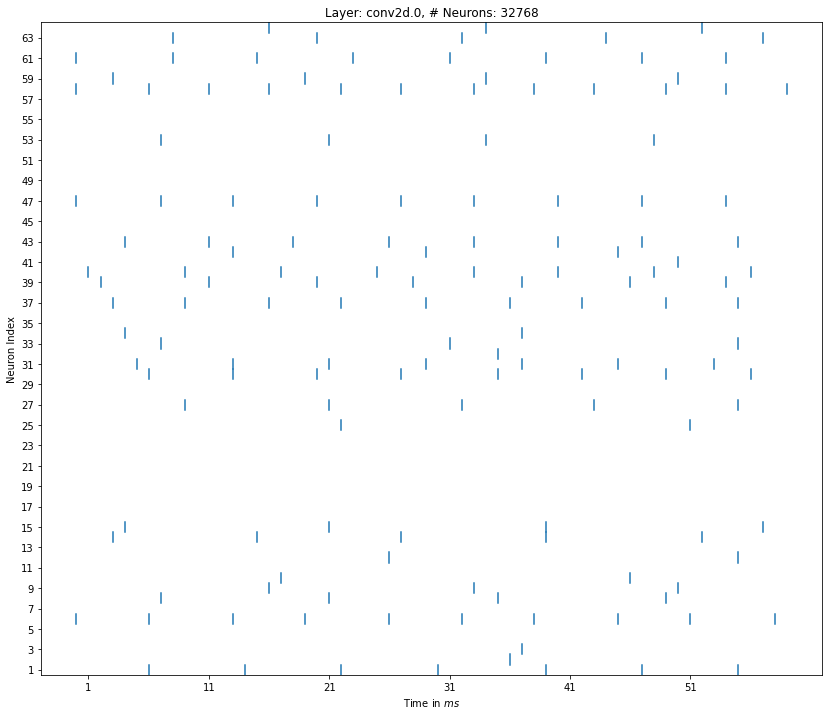

In [8]:
plot_ndl_layer_spikes("conv2d.0", ngo_cfg["sfr"], ndl_model_spks[0]["conv2d.0"], num_random_neurons=64)

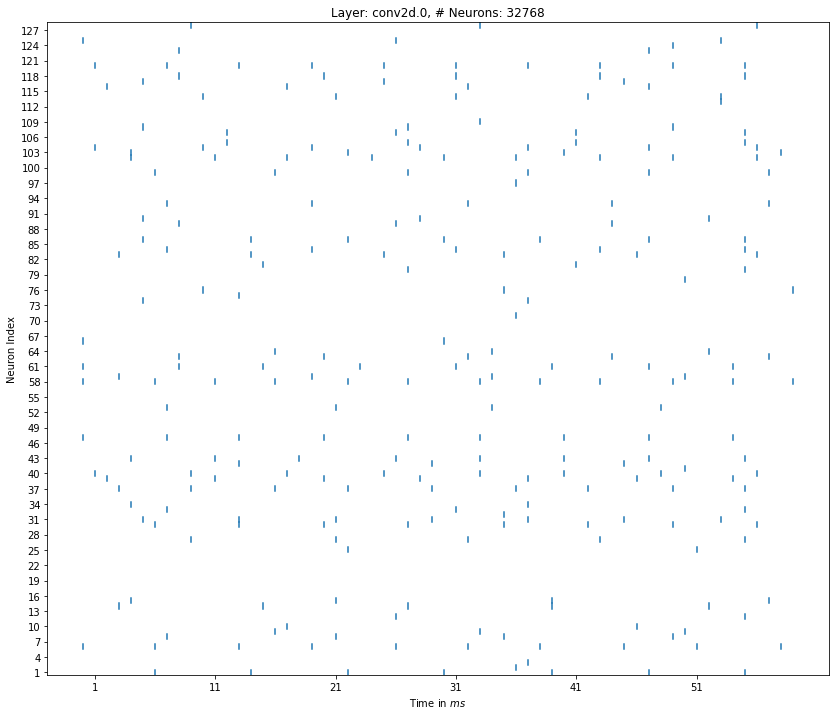

In [9]:
plot_ndl_layer_spikes("conv2d.0", ngo_cfg["sfr"], ndl_model_spks[0]["conv2d.0"], num_random_neurons=128)